# Toy example, compare MLP and Ensemble NC

## Generate Data

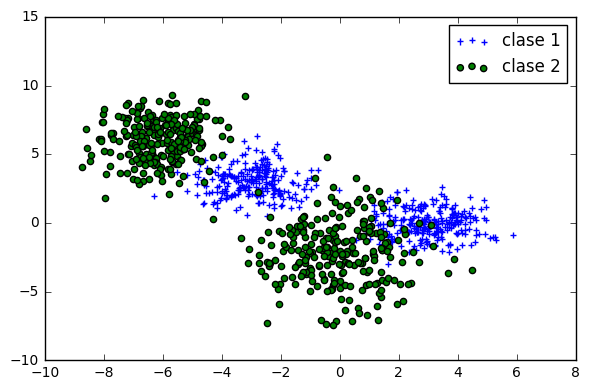

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import scipy
from sklearn import svm
from sklearn import cross_validation
from theano import config

n_class1 = 500
n_class2 = 500

mu_vec11 = np.array([3,0])
cov_mat11 = np.array([[1,0],[0,1]])
x11 = np.random.multivariate_normal(mu_vec11, cov_mat11, n_class1 // 2)

mu_vec12 = np.array([-3,3])
cov_mat12 = np.array([[1,0],[0,1]])
x12 = np.random.multivariate_normal(mu_vec12, cov_mat12, n_class1 // 2)

x1_samples = np.concatenate((x11, x12))

mu_vec21 = np.array([-6,6])
cov_mat21 = np.array([[1,0],[0,2]])
x21 = np.random.multivariate_normal(mu_vec21, cov_mat21, n_class2 // 2)

mu_vec22 = np.array([0,-2])
cov_mat22 = np.array([[2,0],[0,5]])
x22 = np.random.multivariate_normal(mu_vec22, cov_mat22, n_class2 // 2)

x2_samples = np.concatenate((x21, x22))

fig = plt.figure()

plt.scatter(x1_samples[:,0],x1_samples[:,1], marker='+')
plt.scatter(x2_samples[:,0],x2_samples[:,1], c= 'green', marker='o')

X = np.array(np.concatenate((x1_samples,x2_samples), axis = 0), dtype=config.floatX)
Y = np.array([0]*n_class1 + [1]*n_class2, dtype=config.floatX)
classes_names = [0, 1]
labels = ['clase 1', 'clase 2']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, Y, test_size=0.4, random_state=0)

X_train = np.array(X_train, dtype=config.floatX)
X_test = np.array(X_test, dtype=config.floatX)
y_train = np.array(y_train, dtype=config.floatX)
y_test = np.array(y_test, dtype=config.floatX)

plt.legend(labels)
plt.tight_layout()

## Training MLP

In [2]:
from deepensemble.models.sequential import Sequential
from deepensemble.layers.dense import Dense
from deepensemble.utils import *
from deepensemble.metrics import *
import theano.tensor as T

# create MLP
mlp = Sequential("mlp", "classifier", classes_names)
mlp.add_layer(Dense(n_input=X.shape[1], n_output=6, activation=T.tanh))
mlp.add_layer(Dense(n_output=len(classes_names), activation=T.nnet.softmax))
mlp.append_cost(mse)
mlp.set_update(sgd, learning_rate=0.1)
mlp.compile(fast=True)

max_epoch = 200  # max epoch training

metrics_mlp = FactoryMetrics.get_metric(mlp)

metric = mlp.fit(X_train, y_train, max_epoch=max_epoch, batch_size=32)

metrics_mlp.append_prediction(y_test, mlp.predict(X_test))
metrics_mlp.append_metric(metric)

metrics_mlp.classification_report()

Start Compile mlp  - elapsed: 1.67 [s]
mlp - epoch:[####################] 200/200 elapsed: 0.64[s] - left: 0.00[s] 
             precision    recall  f1-score   support

          0       0.89      0.98      0.93       206
          1       0.98      0.87      0.92       194

avg / total       0.93      0.93      0.92       400



## Training Ensemble

In [3]:
from deepensemble.models.ensemblemodel import EnsembleModel
from deepensemble.combiner import *

# create ensemble
ensemble = EnsembleModel(name="Ensemble")

# Create models for ensemble
for i in range(3):
    net = Sequential("net%d_ens" % i, "classifier", classes_names)
    net.add_layer(Dense(n_input=X.shape[1], n_output=2, activation=T.tanh))
    net.add_layer(Dense(n_output=len(classes_names), activation=T.nnet.softmax))
    net.append_cost(mse)
    net.set_update(sgd, learning_rate=0.1)
    ensemble.append_model(net)

ensemble.add_cost_ensemble(fun_cost=test_cost, lamb=10000000.)  # adds neg correlation in all models
ensemble.set_combiner(PluralityVotingCombiner())
ensemble.compile(fast=True)

metrics_ensemble = FactoryMetrics.get_metric(ensemble)

metric = ensemble.fit(X_train, y_train, max_epoch=max_epoch, batch_size=32)

metrics_ensemble.append_prediction(y_test, ensemble.predict(X_test))
metrics_ensemble.append_prediction_per_model(X_test, y_test)
metrics_ensemble.append_metric(metric)

metrics_ensemble.classification_report()

Start Compile Ensemble  - elapsed: 18.03 [s]
Ensemble - epoch:[############........] 128/200 elapsed: 0.69[s] - left: 0.39[s] 
             precision    recall  f1-score   support

          0       0.88      0.82      0.85       206
          1       0.82      0.89      0.85       194

avg / total       0.85      0.85      0.85       400



## Plot MLP vs Ensemble

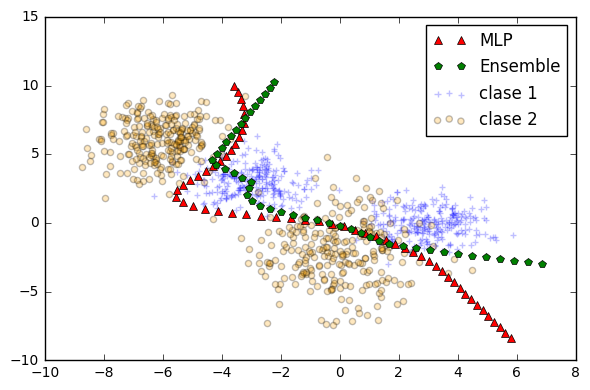

In [4]:
import matplotlib._cntr as cntr

h = .02  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
x = np.array(np.c_[xx.ravel(), yy.ravel()], dtype=config.floatX)
Z1 = mlp.predict(x)
Z2 = ensemble.predict(x)

# Put the result into a color plot
z1 = Z1.reshape(xx.shape)
z2 = Z2.reshape(xx.shape)

def get_contour(x, y, z):
    c = cntr.Cntr(x, y, z)
    level = 0.5
    nlist = c.trace(level, level, 0)
    segs = nlist[:len(nlist)//2]
    x1 = []
    y1 = []
    for seg in segs:
        x1 = np.concatenate((x1, seg[:,0]))
        y1 = np.concatenate((y1, seg[:,1]))
    return x1, y1


xx1, yy1 = get_contour(xx, yy, z1)
xx2, yy2 = get_contour(xx, yy, z2)

fig = plt.figure()
plt.plot(xx1[0::30], yy1[0::30], '^r', linewidth=2)
plt.plot(xx2[0::30], yy2[0::30], 'pg', linewidth=2)
plt.scatter(x1_samples[:,0],x1_samples[:,1], marker='+', alpha=0.25)
plt.scatter(x2_samples[:,0],x2_samples[:,1], c='orange', marker='o', alpha=0.25)
plt.legend(['MLP', 'Ensemble'] + labels)
plt.tight_layout()

## Plot Models Ensemble

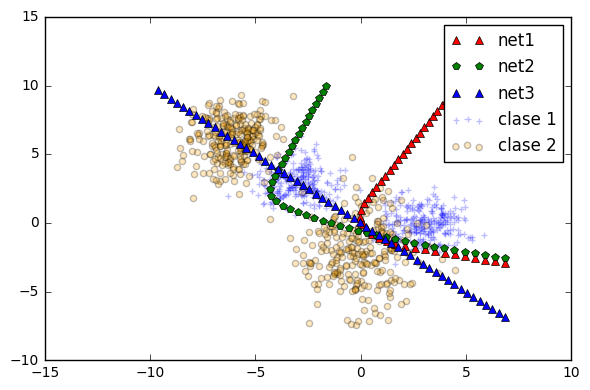

In [5]:

Z21 = ensemble.get_models()[0].predict(x)
Z22 = ensemble.get_models()[1].predict(x)
Z23 = ensemble.get_models()[2].predict(x)

# Put the result into a color plot
z21 = Z21.reshape(xx.shape)
z22 = Z22.reshape(xx.shape)
z23 = Z23.reshape(xx.shape)

xx21, yy21 = get_contour(xx, yy, z21)
xx22, yy22 = get_contour(xx, yy, z22)
xx23, yy23 = get_contour(xx, yy, z23)

fig = plt.figure()
plt.plot(xx21[0::30], yy21[0::30], '^r', linewidth=2)
plt.plot(xx22[0::30], yy22[0::30], 'pg', linewidth=2)
plt.plot(xx23[0::30], yy23[0::30], '^b', linewidth=2)
plt.scatter(x1_samples[:,0],x1_samples[:,1], marker='+', alpha=0.25)
plt.scatter(x2_samples[:,0],x2_samples[:,1], c='orange', marker='o', alpha=0.25)
plt.legend(['net1', 'net2', 'net3'] + labels)
plt.tight_layout()